## Welcome to E-tivity 2, Task 2: Convolutional Neural Networks

Your Name: Zheng Hanming

Your Student ID Number: 21225621

### Objective:
*Construct a Convolutional Neural Network to predict future index prices / returns*

### More Information: Exploring the Limitations of Neural Networks
#### Convolutional Neural Networks for Time Series Forecasting
##### Predicting Weekly S&P500 Index Prices using Historical Observations

Let's visit a controversial area - an area where Deep Learning may *technically* offer improvement, but not much functional improvement.
- It is controversial as the suggestion that future prices can be predicted solely on the basis of historical observations
is a violation of the **weak form of the Efficient Market Hypothesis**, which implies that the current share price already reflects
all relevant market actions on the stock and, as such, there is no 'hidden information' to be found in the prior movements of prices.
- Nevertheless, this approach has been used as a 'showcase' in Deep Learning for Finance books, and in online tutorials.
- It also dispels the myth that Deep Learning is a panacea that can overcome any statistical challenge with brute computational force.

This Notebook first demonstrates how to predict **index prices**, based solely on historical values.

After that, **you** will be required to predict index price _changes_ (**log returns** specifically), based solely on historical values

You will complete the subtasks using Convolutional Neural Nets, which found prominence in image classification tasks (such as object detection and semantic segmentation) and natural language processing
(such as speech recognition), but has also been proposed as a useful method for forecasting time series.

Why are we using CNNs for time series here?

- CNNs are often **better at finding local patterns** because the main assumption of CNNs is that the same local
patterns are relevant everywhere. So recurring 'jumps' will be spotted and incorporated in to predictions if their hallmarks
are spotted in the prevailing values to be predicted. This has the very beneficial property that **CNNs tend to be more
computationally efficient** because there are fewer sequential calculations - each filter forms only a small representation
of the entirety of the data, which is then built up at the end when the feature maps are flattened.

### PyTorch
Note that for this module, we will be implementing neural networks using PyTorch instead of TensorFlow or Keras. You can
find out more about PyTorch here: https://pytorch.org/features/.

#### Install required packages and libraries:

In [ ]:
# !pip install -U setuptools
# !pip install pandas numpy matplotlib missingno scikit-learn seaborn torch torchinfo yfinance

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import traceback, re
import torch
import seaborn as sns
import yfinance as yf

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

from torch.utils.data import (TensorDataset, DataLoader, Subset)
from torch import (nn, optim)
from torchinfo import summary

%matplotlib inline
print(torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# setting seed for reproducibility - please do not change
torch.manual_seed(1)

2.0.0+cpu


## Subtask 1: Use the YFinance Package to set up our Dataset

In this Notebook, you will attempt to forecast prices and returns for the S&P500, which has the ticker `^GSPC` on Yahoo Finance
(alternatively, you can use the `SPY` ticker, which is a tradable ETF [a stock-like fund] that tracks the S&P500's
movements with a high degree of precision).

You will draw on weekly data from the beginning of 2010 to the end of the 2019, covering the span of the 2010s, to use as
training data in order to forecast how prices and returns should change post-2020. You will be using the Yahoo Finance package to access relevant data.

### Required:
1. Download the data from Yahoo Finance, using a `period` input of 1 day.
2. Reconfigure the dataframe in order to look at weekly data rather than daily data (this has been done for you)
3. Extract the adjusted close price values from the `weekly_ticker_information` dataframe
4. Create log returns using the adjusted close prices from the `weekly_ticker_information` dataframe

*Hint:*
- *Step 1: You can find the `yfinance` documentation here: https://pypi.org/project/yfinance/. You will be passing through
ticker, start/end date, and period parameters*
- *Step 3: You may find benefit from the `.values` command: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.values.html*
- *Step 4: You may construct the log returns in any fashion you like as long as the final result is a numpy array, but you
 find benefit from using a combination of the `np.log()` and `.shift()` functions: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html*

In [ ]:
# yfinance function parameters - please do not change
ticker = '^GSPC'
start_date = '2010-01-02'
end_date = '2022-12-31'
valid_start = '2020-01-01'
test_start = '2022-01-01'

#*** YOUR CODE STARTS HERE ***#
ticker_information = yf.download(ticker, start=start_date, end=end_date, period='1d') # Download daily values using period = '1d'
weekly_ticker_information = ticker_information.resample('W-MON').last() # resampling the daily data in to weekly data
prices = weekly_ticker_information['Adj Close'] # extracting the 'Adjusted Close' prices form the weekly ticker dataframe
returns = np.log(prices).diff() # calculating log returns using the .shift() function. Do not include a 'fill_value' term https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html
returns.head()
# NOTE: instruction says returns must be numpy array but the below code will fail, dataframe works, so it is left as df
#*** YOUR CODE ENDS HERE ***#

[*********************100%***********************]  1 of 1 completed


Date
2010-01-04         NaN
2010-01-11    0.012272
2010-01-18   -0.009593
2010-01-25   -0.035161
2010-02-01   -0.006944
Freq: W-MON, Name: Adj Close, dtype: float64

The first return will be an 'NaN', so we remove it from our dataset, and scale the percentage values upwards by multiplying
returns by 100. For parity, we will also remove the first value in the dataframe too. Finally, I specify through the
`N_LAGS` parameter how many prior observations I will be using to support our forecast for the next price.

With the removal of the NaN, and by specifying how many historical observations will be used to forecast the following S&P500
 price, we can take a look at the series we will be predicting.

In [ ]:
weekly_ticker_information = weekly_ticker_information.iloc[1:]
prices = prices[1:]
returns = returns.iloc[1:].values*100
N_LAGS = 16

## Start of Demonstration
### Note: The next set of subtasks begins on Line 575.
*Lines 133 - 574 contain a demonstration on how CNNs can be applied on sequential data (prices). Following this demonstration,
you are required to apply CNNs on a different set of sequential data (returns). I advise that you make use of the steps carried out in the 'demonstration'
portion of this notebook to guide your implementations in the relevant subtasks from lines 563 onwards.*

#### Plotting our Data

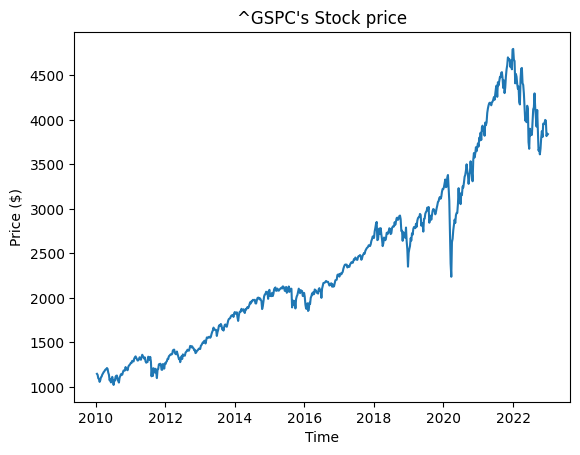

In [ ]:
fig, ax = plt.subplots()
ax.plot(weekly_ticker_information.index, prices)
ax.set(title=f"{ticker}'s Stock price",
       xlabel='Time',
       ylabel='Price ($)');

Strong upward trend in the time series for index prices.

#### Scale the prices to be centered on zero and have 1 standard deviation.

In [ ]:
price_scaler = preprocessing.StandardScaler()
valid_size = weekly_ticker_information.loc[valid_start:test_start].shape[0]
test_size = weekly_ticker_information.loc[test_start:end_date].shape[0]
price_scaler.fit(np.expand_dims(prices[:len(prices) - valid_size - test_size], axis = 1))
prices_scaled = price_scaler.transform(np.expand_dims(prices, axis = 1)).flatten()

#### Transform the time series into input for the CNN, using the `construct_data` function:

Since our predictions will be formed solely on the basis of historical observations, from the perspective of the model,
for each 'y' value to be predicted, we will set our prior observations as 'independent variables'.

The number of prior observations that the model will consider (i.e. the number of independent variables that will support
predictions) when training on the 'y' values is the number of 'lags' that have been specified by the user.

In order to construct a dataset that is interpretable by the model, a **'rolling window'** method is set up.

In [ ]:
def construct_data(time_series, n_lags, n_leads=1):
    X = []
    y = []
    for start_lookback_window in range(len(time_series) - n_lags - n_leads + 1):
        end_lookback_window = start_lookback_window + n_lags
        end_lookahead_window = end_lookback_window + n_leads
        X.append(time_series[start_lookback_window:end_lookback_window])
        y.append(time_series[end_lookback_window:end_lookahead_window])
    return np.array(X), np.array(y)

#### Some notes on interpreting the above function

**Range**: Why are values being subtracted from the length of the series?

If we, for example, are predicting the 6th value of 'y' and using a Lag of 5, then we are effectively using the first
5 observations to train the model. Therefore, we cannot make any predictions for the first 5 observations (since there
will be no prior '5 observations' upon which we can compute our prediction). Hence, we remove the number of 'lags' from our trainable dataset.

Similarly, if we wanted to predict two periods ahead (two 'leading' values) for each observation, we must allocate space
for the two periods we are predicting - consider the case where we reach the last observation of our training set. We
cannot train on the effectiveness of our two predicted observations when there is only one more to use as a benchmark
reference. Hence, we also remove the number of 'leads' from our trainable dataset.

+1 is added because index values in python start at 0, whereas we are trying to report the length of a dataset.

Breaking down the function:

1. **end_lookback_window** = final index position of our predictors, made up of our current index position (start_lookback_window) + the number of observations we want to use as predictors for our predictions (n_lags).
2. **end_lookahead_window** = final index position of our predictions (i.e. index position when we start predicting +
the number of predictions to be made).
3. **X** is appended with all values between our current index position and the last observation we use before making predictions.
4. **y** is appended with all values between end_lookback_window and end_lookahead_window - comprising the number of predictions we want to make.

In [ ]:
X_prices, y_prices = construct_data(prices_scaled, N_LAGS)

We have now constructed a numpy array where we have 16 'independent variables' and 1 'target variable'.
Target Variable = today's index price, Independent Variables = last 16 index prices

#### Let's take a peek at the correlations - is there a relationship between successive prices?

In [ ]:
Combined = pd.DataFrame(X_prices)
Combined['Target'] = y_prices

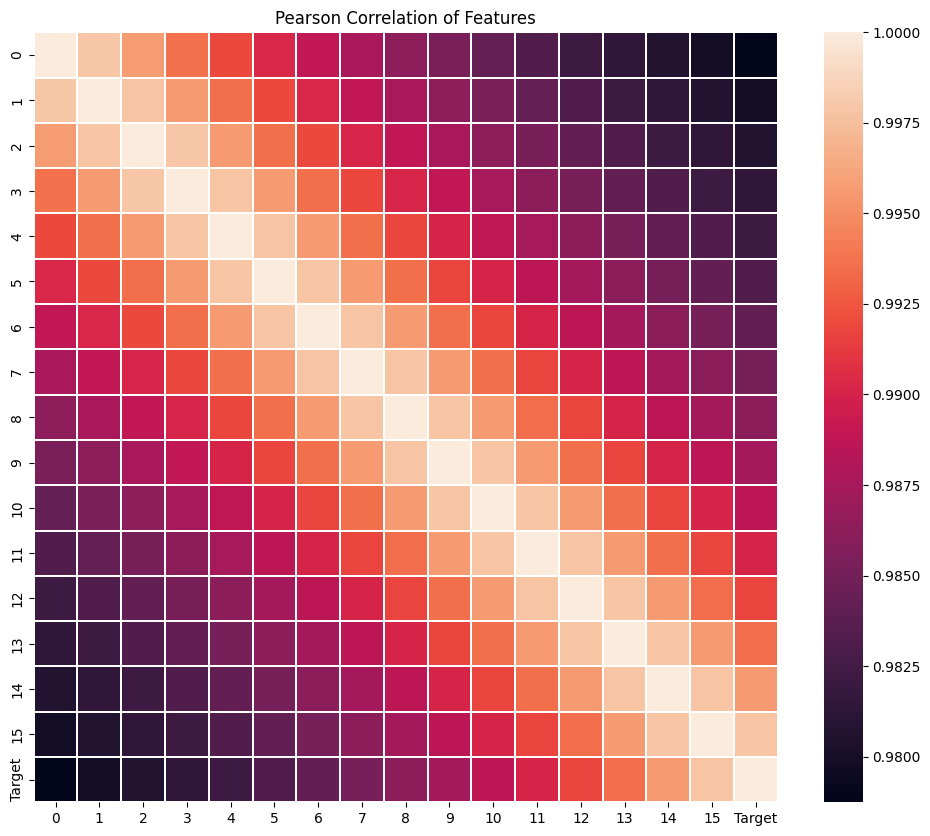

In [ ]:
plt.figure(figsize = (12, 10))
plt.title('Pearson Correlation of Features')
sns.heatmap(Combined.corr(), linewidths = 0.1, linecolor = 'white')
plt.show()

There appears to be a long-reaching, strong correlation between prices, that only gets stronger as the price gets closer
to the 'target price'. No surprises there. It makes for a nice graph, but raises significant concerns in terms of
autocorrelations of observations. We can also directly inspect the correlation between the features and the target:

In [ ]:
pd.DataFrame(Combined).select_dtypes(include='number').corr()[['Target']]

Target
0       0.978739
1       0.979779
2       0.980694
3       0.981433
4       0.982171
5       0.983154
6       0.984173
7       0.985193
8       0.986193
9       0.987424
10      0.988698
11      0.990047
12      0.991742
13      0.993497
14      0.995605
15      0.997799
Target  1.000000

The numerical correlations verify the story being told in the heatmap above - serial correlation may turn out to be a big
hindrance in the performance of our model.

Now that we have the datasets defined (note we do not shuffle the data, as order matters in time series), we split the data in to validation and test sets.

- Note that we have already defined the _beginning_ and _end_ dates for the entire dataset at the beginning of the workbook.
    - The **training set** will comprise all values from the **start date** to the **date the 'validation' set starts**.
    - The **validation set** will comprise all values from the **date the 'validation' set starts**, to the **date the 'test' set starts**.
    - The **test set** will comprise all values from the **date the 'test' set starts**, to the **date the dataset ends**.

In [ ]:
y_price_valid = prices[len(prices) - valid_size - test_size:len(prices) - test_size]
y_price_test = prices[len(prices) - test_size:]

#### Obtain the naïve forecast for the validation set:
- The 'naive' prediction is to use the last observed value as the next prediction.

In [ ]:
naive_valid_price = prices[len(prices) - valid_size - test_size - 1:len(prices) - test_size -1]

naive_mse = mean_squared_error(y_price_valid, naive_valid_price)
naive_rmse = np.sqrt(naive_mse)
print(f"The baseline naive forecast to 'beat' is - MSE: {naive_mse:.2f}, RMSE: {naive_rmse:.2f}")

The baseline naive forecast to 'beat' is - MSE: 10412.86, RMSE: 102.04


#### Turning the dataset into tensors, so they can be passed into the model (a necessary step in PyTorch).

In [ ]:
X_tensor = torch.from_numpy(X_prices).float()
y_tensor = torch.from_numpy(y_prices).float().unsqueeze(dim=1)
dataset = TensorDataset(X_tensor, y_tensor)

#### Creating subsets of data from the tensor (designating the training set, validation set, and test set).

In [ ]:
BATCH_SIZE = 5
end_training_range = len(X_prices) - valid_size - test_size
end_validation_range = len(X_prices) - test_size

train_dataset = Subset(dataset, list(range(end_training_range)))
valid_dataset = Subset(dataset, list(range(end_training_range, end_validation_range)))
test_dataset = Subset(dataset, list(range(end_validation_range, len(X_prices))))

#### Allocate the size of the mini-batches to be loaded into the model once it begins computing.

In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

Check the size of the datasets:

In [ ]:
print(f'Size of datasets - training: {len(train_loader.dataset)} | validation: {len(valid_loader.dataset)}')

Size of datasets - training: 506 | validation: 104


#### Define the CNN's architecture:

Note that `nn.Sequential` is used here to string together several layers that run one after another. This approach to constructing
the neural network architecture may be easier to conceptualise than the approach used in E-tivity 1 and  E-tivity 2
Task 1, where the layers could be defined in any order, and the order only mattered in the `forward` function.

In [ ]:
class CNN(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

price_model = nn.Sequential(
        nn.Conv1d(1, 64, kernel_size= 7, stride=1, padding=1),
        nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
        nn.ReLU(),
        nn.Conv1d(64, 128, kernel_size= 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(128*3, 50),
        nn.ReLU(),
        nn.Linear(50, 1)
).to(device)

#### Inspecting the model, prior to it being run

It is always a good idea to map out the matrix calculations that will be performed in a CNN ahead of time to avoid unnecessary errors.
We can track the shape of the data (noting that W = number of features, or independent variables) as it is continuously transforms while progressing through the model.

To calculate the changing shape of the network, use the
$\lfloor \frac{Width of Representation - Filter Size + (2 \times Padding)}{Stride} +1 \rfloor$ formula or, more succinctly,
$\lfloor \frac{W-F+(2\times P)}{S} +1 \rfloor$. The resulting network shape should always be stated in integers, so the
'side brackets' indicate that the floor of the result should be taken (i.e. if the formula outputs 2.5, the result is 2).

Note that once the Batch Size has been designated in the input shape, it is no longer relevant in calculations - it remains constant throughout.
What matters is the size of the sequences being fed into the model (in our case, one observation at a time), and more importantly keeping track
of the number of features as they get compressed in favour of a **deeper** model (represented by an increasing number of channels, or **feature maps**).

1. Conv1d: $\lfloor \frac{16-7+(2\times 1)}{1} +1 \rfloor$ = 12
2. MaxPool1d: $\lfloor \frac{12-2+(2\times 0)}{2} +1 \rfloor$ = 6
3. Conv1d: $\lfloor \frac{6-3+(2\times 1)}{2} +1 \rfloor$ = 3

By the time we have reached the 2nd convolutional layer, the feature width has been reduced to 3, but we now have 128 feature maps that represent the
information that was originally contained within the 16 features.

5. Flatten: Squash 3-D data with volume 128 into a 1-D vector: [Channels $\times$ Representative Width] = $[128 \times 3] = [384]$
6. Linear w/ Dropout: $[128 \times 3$ neurons = 384] $ \rightarrow $ [50 neurons]
7. Linear: [50 neurons] $\rightarrow$ [1 neuron] a.k.a our prediction.

We can verify the accuracy of our back-of-the-envelope calculations by looking at:

1. `print(model)`, and/or
2. a `summary` of the model, where `input_size` = (Batch Size = 5, Height = 1, Width = 16, Depth):
    - Height = 1 since observations are assessed one at a time, in batches of 16 (unrelated to the number of lags).
    - Width = Number of features /independent vars / prior observations used to make a prediction
    - Depth is not included as the data is 2-dimensional (would be required if dealing with 3-D+ data like images).

In [ ]:
print(price_model)
summary(price_model, input_size=(BATCH_SIZE, 1, X_prices.shape[1]))

Sequential(
  (0): Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(1,))
  (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
  (4): ReLU()
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=384, out_features=50, bias=True)
  (7): ReLU()
  (8): Linear(in_features=50, out_features=1, bias=True)
)


C:\Users\zhanming\Anaconda3\envs\pytorch\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
C:\Users\zhanming\Anaconda3\envs\pytorch\lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [5, 1]                    --
├─Conv1d: 1-1                            [5, 64, 12]               512
├─MaxPool1d: 1-2                         [5, 64, 6]                --
├─ReLU: 1-3                              [5, 64, 6]                --
├─Conv1d: 1-4                            [5, 128, 3]               24,704
├─ReLU: 1-5                              [5, 128, 3]               --
├─Flatten: 1-6                           [5, 384]                  --
├─Linear: 1-7                            [5, 50]                   19,250
├─ReLU: 1-8                              [5, 50]                   --
├─Linear: 1-9                            [5, 1]                    51
Total params: 44,517
Trainable params: 44,517
Non-trainable params: 0
Total mult-adds (M): 0.50
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.18
Estimated Total Size (MB): 0.23

Our calculations were correct! Although we can call `summary`, it is good practice to get in the habit of completing these
 calculations yourself if applying CNNs to a problem.

#### Run, Train, and Validate the Efficacy of the Neural Network architecture.

In [ ]:
def run_model(nn_model, loss_fn, n_epochs, learning_rate, print_every):
    train_losses, valid_losses = [], []

    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    var_name = re.compile(r'\((.*)\).*$').search(code).groups()[0].split(",", 1)[0]

    optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate)

    for epoch in range(n_epochs):
        running_loss_train = 0
        running_loss_valid = 0

        nn_model.train()

        for x_batch, y_batch in train_loader:

            optimizer.zero_grad()
            x_batch = x_batch.to(device).view(x_batch.shape[0], 1, N_LAGS)
            y_batch = y_batch.to(device).view(y_batch.shape[0], 1, 1)
            y_hat = nn_model(x_batch).view(y_batch.shape[0], 1, 1)
            loss = loss_fn(y_hat,y_batch)
            loss.backward()
            optimizer.step()
            running_loss_train += loss.item() * x_batch.size(0)

        epoch_loss_train = running_loss_train / len(train_loader.dataset)
        train_losses.append(epoch_loss_train)

        with torch.no_grad():

            nn_model.eval()

            for x_val, y_val in valid_loader:
                x_val = x_val.to(device).view(x_val.shape[0], 1, N_LAGS)
                y_val = y_val.to(device).view(y_val.shape[0], 1, 1)
                y_hat = nn_model(x_val).view(y_val.shape[0], 1, 1)
                loss = loss_fn(y_hat,y_val)
                running_loss_valid += loss.item() * x_val.size(0)

            epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)

            if epoch > 0 and epoch_loss_valid < min(valid_losses):
                best_epoch = epoch
                torch.save(nn_model.state_dict(), f'./{var_name}_checkpoint.pth')

            valid_losses.append(epoch_loss_valid)
        if epoch % print_every == 0:
            print(f"<{epoch}> - Train. loss: {epoch_loss_train:.2f} \t Valid. loss: {epoch_loss_valid:.2f}")
    print(f'Lowest loss recorded in epoch: {best_epoch}')
    return train_losses, valid_losses

In [ ]:
train_losses, valid_losses = run_model(price_model, nn.L1Loss(), 300, 10**-4, 25)

<0> - Train. loss: 0.65 	 Valid. loss: 1.31
<25> - Train. loss: 0.09 	 Valid. loss: 0.21
<50> - Train. loss: 0.07 	 Valid. loss: 0.19
<75> - Train. loss: 0.06 	 Valid. loss: 0.28
<100> - Train. loss: 0.06 	 Valid. loss: 0.28
<125> - Train. loss: 0.05 	 Valid. loss: 0.24
<150> - Train. loss: 0.05 	 Valid. loss: 0.23
<175> - Train. loss: 0.05 	 Valid. loss: 0.21
<200> - Train. loss: 0.05 	 Valid. loss: 0.21
<225> - Train. loss: 0.05 	 Valid. loss: 0.27
<250> - Train. loss: 0.08 	 Valid. loss: 0.21
<275> - Train. loss: 0.05 	 Valid. loss: 0.29
Lowest loss recorded in epoch: 248


Note that we are using MAE loss instead of MSE loss in this Notebook

#### Plot the losses over epochs:

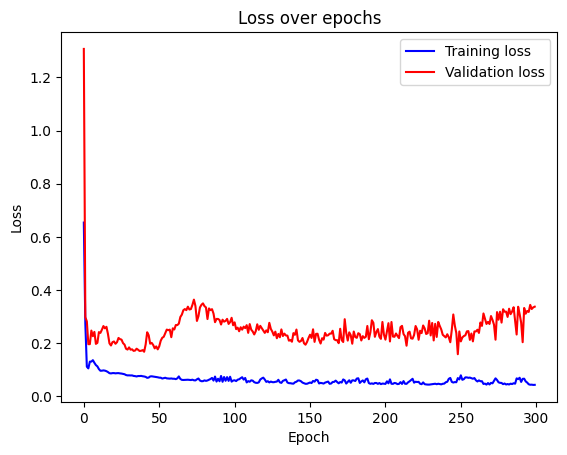

In [ ]:
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)

fig, ax = plt.subplots()

ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='red', label='Validation loss')

ax.set(title="Loss over epochs",
       xlabel='Epoch',
       ylabel='Loss')
ax.legend()

plt.show()

Based on the loss recorded each epoch, the weights adjust until a minimised loss is found. The model appears
to find a minimum loss at around **epoch 230**.

Let's see if the trained 'best fit' model:

1. Improves on the naive estimate, and
2. Could be used as a 'signal'.

We choose our 'best fit' model on the basis of the weights and bias that generated the lowest validation loss.

#### Load the best model (with the lowest validation loss):

In [ ]:
state_dict = torch.load('price_model_checkpoint.pth')
price_model.load_state_dict(state_dict)

<All keys matched successfully>

#### Obtain the predictions:

In [ ]:
y_price_pred, y_price_valid = [], []

with torch.no_grad():

    price_model.eval()

    for x_val, y_val in valid_loader:
        x_val = x_val.to(device)
        x_val = x_val.view(x_val.shape[0], 1, N_LAGS)
        y_price_pred.append(price_model(x_val))
        y_price_valid.append(y_val)

y_price_pred = torch.cat(y_price_pred).numpy()
y_price_pred = price_scaler.inverse_transform(y_price_pred).flatten()
y_price_valid = torch.cat(y_price_valid).view(valid_size,1).numpy()
y_price_valid = price_scaler.inverse_transform(y_price_valid).flatten()

#### Evaluate the predictions:

The baseline naive forecast to 'beat' is - MSE: 10412.86, RMSE: 102.04
CNN's forecast - MSE: 16886.16, RMSE: 129.95


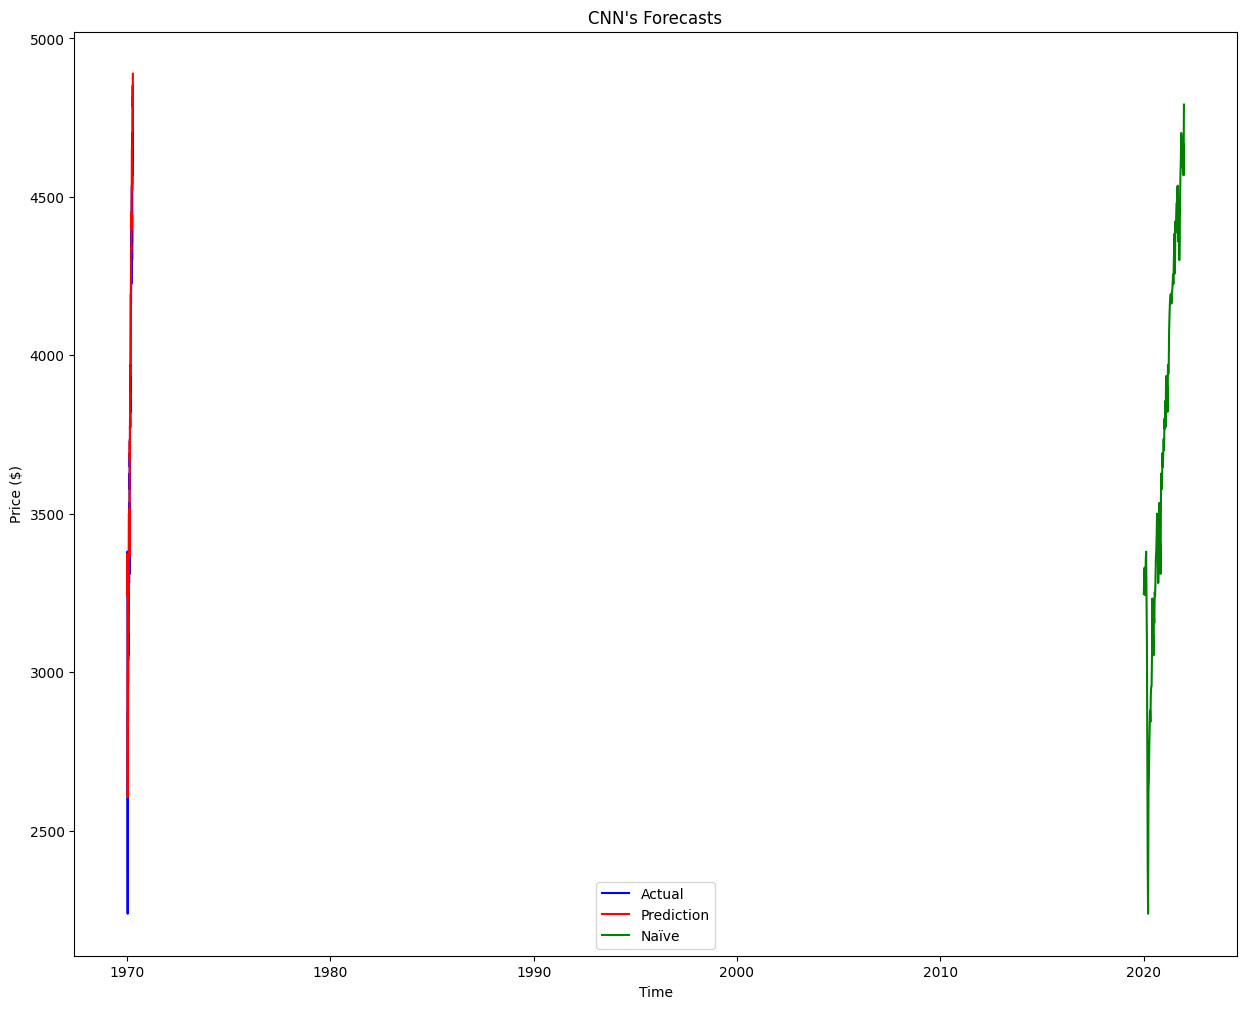

In [ ]:
cnn_mse = mean_squared_error(y_price_valid, y_price_pred)
cnn_rmse = np.sqrt(cnn_mse)
print(f"The baseline naive forecast to 'beat' is - MSE: {naive_mse:.2f}, RMSE: {naive_rmse:.2f}")
print(f"CNN's forecast - MSE: {cnn_mse:.2f}, RMSE: {cnn_rmse:.2f}")


fig, ax = plt.subplots(figsize = (15, 12))

ax.plot(y_price_valid, color='blue', label='Actual')
ax.plot(y_price_pred, color='red', label='Prediction')
ax.plot(naive_valid_price, color='green', label='Naïve')

ax.set(title="CNN's Forecasts",
       xlabel='Time',
       ylabel='Price ($)')
ax.legend()

plt.show()

We struggle to improve on our 'naive' estimate. The plot of our estimates vs. the actual values appears at
first glance to be a rather good estimate, but upon closer inspection it is not.

Our predictions are adjustments to the naive approach, rather than attempting to track close to the actual `y` values.
In other words, the predictions are not independently determined by the model - they are mostly just replications of the
price the week before with slight variations. Ultimately, there is little to suggest any practical 'learning' by the model.

Regardless of the financial theory underlying the prediction of stock prices from prior values, from a statistical learning
standpoint this raises one of the reasons why we try to avoid autocorrelations in our data- the historical observations
were **_so_** correlated that the model could not find any flexibility to determine it's own means of a best fit to the data.

There is reason to suggest that the poor performance of the 'index price' prediction model is down to the significant
level of autocorrelation found amongst successive index prices. But what about index price **_returns_**? They may be less
correlated - in fact they are very noisy data. Nevertheless, if we _could_ find some signal in the returns, we could
outperform the predictions produced by the Index Price Prediction model.

## End of Demonstration, start of Implementation

#### Instead of Index Prices, let's consider predicting returns, and adding our predictions on to the previous week's index price so that we can (hopefully) get a more accurate estimate.

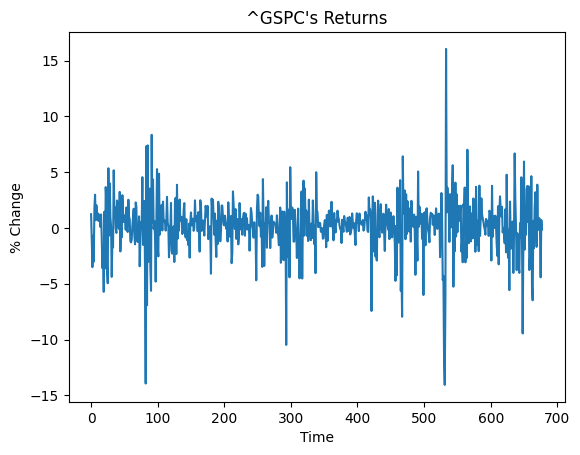

In [ ]:
fig, ax = plt.subplots()

ax.plot(returns)
ax.set(title=f"{ticker}'s Returns",
       xlabel='Time',
       ylabel='% Change');

Returns display no trend and are very noisy - as expected.

## Subtask 2

### Required
Implement a `StandardScaler` operation to rescale the `returns` data, which have previously been sized up to be represented in unit form instead of decimal form.

*Hint: you can rescale the returns in the same fashion as the rescaling operation performed on the `prices` data.*

In [ ]:
#*** YOUR CODE STARTS HERE ***#
returns_scaler = preprocessing.StandardScaler()
valid_size = weekly_ticker_information.loc[valid_start:test_start].shape[0]
test_size = weekly_ticker_information.loc[test_start:end_date].shape[0]
returns_scaler.fit(np.expand_dims(returns[:len(returns) - valid_size - test_size], axis = 1))
returns_scaled = returns_scaler.transform(np.expand_dims(returns, axis = 1)).flatten()
#*** YOUR CODE ENDS HERE ***#

## Subtask 3

### Required
Use the `construct_data` function to split the historical returns into X_returns and Y_returns arrays, according to the
number of lags specified at the beginning of the notebook. In other words, the number of prior observations that the model
will consider (i.e. the number of independent variables that will support predictions) when training on the 'y' values is
the number of 'lags' that have been specified by the user.

In [ ]:
#*** YOUR CODE STARTS HERE ***#
X_returns, y_returns = construct_data(returns_scaled, N_LAGS)
#*** YOUR CODE ENDS HERE ***#

## Subtask 4:

### Required
Turn `X_returns` into a `pandas` dataframe and create a correlation matrix using the `.corr()` function.
- *Note: You don't need to produce the heatmap that featured in the Demonstration portion of the Notebook*

**Please specify which <u>two</u> 'variables' have the highest correlations with the target variable.**

In [ ]:
#*** YOUR CODE STARTS HERE ***#
Combined = pd.DataFrame(X_returns)
Combined['Target'] = y_returns
pd.DataFrame(Combined).select_dtypes(include='number').corr()[['Target']]
#*** YOUR CODE ENDS HERE ***#

Target
0       0.036222
1       0.010803
2       0.022366
3       0.004649
4      -0.042599
5      -0.016644
6      -0.028991
7      -0.061741
8       0.053985
9      -0.025060
10      0.003098
11     -0.086385
12     -0.022578
13     -0.076108
14     -0.005893
15     -0.058650
Target  1.000000

#### We will again split the data in to validation and test sets, noting that we do not shuffle the data, as order matters in time series.
- The **training set** will comprise all values from the **start date** to the **date the 'validation' set starts**.
- The **validation set** will comprise all values from the **date the 'validation' set starts**, to the **date the 'test' set starts**.
- The **test set** will comprise all values from the **date the 'test' set starts**, to the **date the dataset ends**.

In [ ]:
y_return_valid = returns[len(returns) - valid_size - test_size:len(returns) - test_size]
y_return_test = returns[len(returns) - test_size:]

#### Obtaining the naïve forecast for the validation set, and turning the dataset into tensors, so they can be passed into the model:
The 'naïve' prediction is to use the last observed value as the next prediction.

In [ ]:
naive_valid_return = returns[len(returns) - valid_size - test_size - 1:len(returns) - test_size -1]
naive_mse = mean_squared_error(y_return_valid, naive_valid_return)
naive_rmse = np.sqrt(naive_mse)
print(f"The baseline naive forecast to 'beat' is - MSE: {naive_mse:.2f}%, RMSE: {naive_rmse:.2f}%")

X_returns_tensor = torch.from_numpy(X_returns).float()
y_returns_tensor = torch.from_numpy(y_returns).float().unsqueeze(dim=1)
dataset = TensorDataset(X_returns_tensor, y_returns_tensor)

The baseline naive forecast to 'beat' is - MSE: 18.78%, RMSE: 4.33%


#### Creating subsets of data from the tensor (designating the training set, validation set, and test set in tensor form), and allocating the size of the mini-batches to be loaded into the model once it begins computing.

In [ ]:
BATCH_SIZE = 5
end_training_range = len(X_returns) - valid_size - test_size
end_validation_range = len(X_returns) - test_size

train_dataset = Subset(dataset, list(range(end_training_range)))
valid_dataset = Subset(dataset, list(range(end_training_range, end_validation_range)))
test_dataset = Subset(dataset, list(range(end_validation_range, len(X_returns))))

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

## Subtask 5:

### Required
Define the CNN architecture using the `nn.Sequential` function according to the instructions below:

- 3 Convolution Layers, with feature maps sizes [1 $\rightarrow$ 32], [32 $\rightarrow$ 64], [64 $\rightarrow$ 128].
	- Each convolutional feature map should be constructed using 3x3 filters and a stride of 1.
	- You should apply 'same' padding on the first convolution layer, and 'valid' padding on the next two.
- 2 Max Pooling layers, to be applied after each of the first 2 Convolution Layers.
	- Both max pooling layers should be implemented with filter size 2 and stride 2, with 'valid' padding.
- 1 `nn.Flatten()` function to transform the weights from feature map representations to vector form.
- 2 Linear Layers, with number of hidden units [128 $\rightarrow$ 64], [64 $\rightarrow$ 1].
	- Randomly deactivate 40% of neurons in the first linear layer
- ReLU non-linear activation functions following each Convolution layer, and following the first (but not the second) Linear layer.
- **Note**: Because we are using the `nn.Sequential` function, the relevant layers and functions must be created in order.

*Hint:*
1. *We are dealing with 2-dimensional data (i.e. a flat matrix and not a colour image with 3 channels), so we will be using
 `nn.Conv1D()` and `nn.MaxPool1d()` layers. The documentation for those functions can be found here: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html, and here: https://pytorch.org/docs/stable/generated/torch.nn.MaxPool1d.html.*
2. *Details on `nn.Linear()`, `nn.Flatten()`, `nn.Dropout()`, and `nn.ReLU()` can be found below:
https://pytorch.org/docs/stable/generated/torch.nn.Linear.html,
https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html,
https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html,
https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html.*

In [ ]:
class CNN(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)
#*** YOUR CODE STARTS HERE ***#
returns_model = nn.Sequential(
    nn.Conv1d(1, 32, stride=1, kernel_size=3, padding='same'), # convo 1->32 stride=1 filter3*3 padding=same([filter-1]/2)
    nn.MaxPool1d(stride=2, kernel_size=2, padding=0), # maxpool stride2 filter2 padding=valid(default)
    nn.ReLU(), # ReLU

    nn.Conv1d(32, 64, stride=1, kernel_size=3, padding='valid'), # convo 32->64 stride=1 filter3*3 padding=valid
    nn.MaxPool1d(stride=2, kernel_size=2, padding=0), # maxpool stride2 filter2 padding=valid(default)
    nn.ReLU(), # ReLU

    nn.Conv1d(64, 128, stride=1, kernel_size=3, padding='valid'), # convo 64->128 stride=1 filter3*3 padding=valid
    nn.ReLU(), # ReLU

    nn.Flatten(),

    nn.Linear(128, 64), # linear 128->64
    nn.ReLU(), # ReLU

    nn.Linear(64, 1), # linear 64->1
).to(device)
print(returns_model)
#*** YOUR CODE ENDS HERE ***#

Sequential(
  (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=same)
  (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=valid)
  (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): ReLU()
  (6): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=valid)
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=128, out_features=64, bias=True)
  (10): ReLU()
  (11): Linear(in_features=64, out_features=1, bias=True)
)


#### Inspecting the model, prior to it being run (checking to see if it works)
- **Spot-check**: There should be 39,361 parameter weights in the model.

In [ ]:
summary(returns_model, input_size=(BATCH_SIZE, 1, X_returns.shape[1]))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [5, 1]                    --
├─Conv1d: 1-1                            [5, 32, 16]               128
├─MaxPool1d: 1-2                         [5, 32, 8]                --
├─ReLU: 1-3                              [5, 32, 8]                --
├─Conv1d: 1-4                            [5, 64, 6]                6,208
├─MaxPool1d: 1-5                         [5, 64, 3]                --
├─ReLU: 1-6                              [5, 64, 3]                --
├─Conv1d: 1-7                            [5, 128, 1]               24,704
├─ReLU: 1-8                              [5, 128, 1]               --
├─Flatten: 1-9                           [5, 128]                  --
├─Linear: 1-10                           [5, 64]                   8,256
├─ReLU: 1-11                             [5, 64]                   --
├─Linear: 1-12                           [5, 1]                    65
Tota

## Subtask 6:

### Required
Run and train the `returns_model` CNN using the `run_model` function, and according to the following hyperparameters
- Neural Network = `returns model`
- Loss function = Mean Absolute Error
- Number of Epochs = 500
- Learning Rate = 0.00001
- `print_every` = 25

In [ ]:
#*** YOUR CODE STARTS HERE ***#
return_train_losses, return_valid_losses = run_model(returns_model, nn.L1Loss(), 500, 0.00001, 25)
#*** YOUR CODE ENDS HERE ***#

<0> - Train. loss: 0.69 	 Valid. loss: 1.03
<25> - Train. loss: 0.67 	 Valid. loss: 1.00
<50> - Train. loss: 0.66 	 Valid. loss: 1.00
<75> - Train. loss: 0.65 	 Valid. loss: 1.00
<100> - Train. loss: 0.63 	 Valid. loss: 1.01
<125> - Train. loss: 0.61 	 Valid. loss: 1.02
<150> - Train. loss: 0.60 	 Valid. loss: 1.02
<175> - Train. loss: 0.58 	 Valid. loss: 1.03
<200> - Train. loss: 0.57 	 Valid. loss: 1.03
<225> - Train. loss: 0.55 	 Valid. loss: 1.03
<250> - Train. loss: 0.53 	 Valid. loss: 1.04
<275> - Train. loss: 0.51 	 Valid. loss: 1.05
<300> - Train. loss: 0.49 	 Valid. loss: 1.05
<325> - Train. loss: 0.48 	 Valid. loss: 1.06
<350> - Train. loss: 0.46 	 Valid. loss: 1.07
<375> - Train. loss: 0.45 	 Valid. loss: 1.08
<400> - Train. loss: 0.44 	 Valid. loss: 1.08
<425> - Train. loss: 0.43 	 Valid. loss: 1.09
<450> - Train. loss: 0.42 	 Valid. loss: 1.09
<475> - Train. loss: 0.41 	 Valid. loss: 1.10
Lowest loss recorded in epoch: 27


#### Plot the losses over epochs:

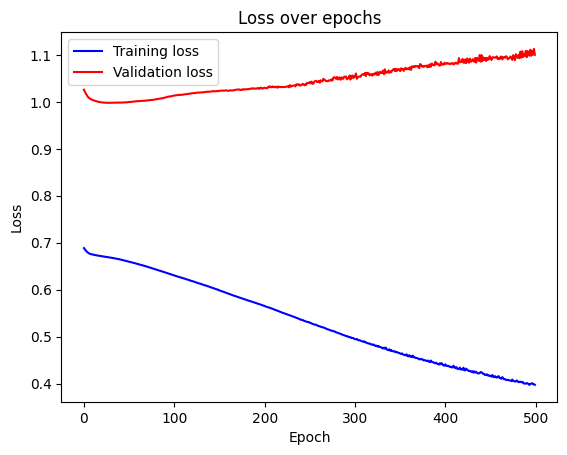

In [ ]:
train_losses = np.array(return_train_losses)
valid_losses = np.array(return_valid_losses)

fig, ax = plt.subplots()

ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='red', label='Validation loss')

ax.set(title="Loss over epochs",
       xlabel='Epoch',
       ylabel='Loss')
ax.legend()

plt.show()

From the loss curves, we can see that the model has no problem with fitting to the observed values in the training
dataset, but the model fails to generalise to previously-unseen data when trying to forecast the 'week-ahead' return.

Given the extent of the observable noisiness in the data and the fact that an overly-positive prediction would violate the weakest
form of the Efficient Market Hypothesis, we can preliminarily conclude that not much is 'learned' solely on the use of
prior returns and we may have to reform our problem to be explored.

Nevertheless, let's continue to inspect our best performing model. We choose our 'best fit' model on the basis of the
weights and bias that generated the lowest validation loss.

#### Load the best model (with the lowest validation loss):

In [ ]:
state_dict = torch.load('returns_model_checkpoint.pth')
returns_model.load_state_dict(state_dict)

<All keys matched successfully>

#### Obtain the predictions:

In [ ]:
y_return_pred, y_return_valid = [], []

with torch.no_grad():

    returns_model.eval()

    for x_val, y_val in valid_loader:
        x_val = x_val.to(device)
        x_val = x_val.view(x_val.shape[0], 1, N_LAGS)
        y_return_pred.append(returns_model(x_val))
        y_return_valid.append(y_val)

y_return_pred = torch.cat(y_return_pred).numpy()
y_return_pred = returns_scaler.inverse_transform(y_return_pred).flatten()
y_return_valid = torch.cat(y_return_valid).view(valid_size,1).numpy()
y_return_valid = returns_scaler.inverse_transform(y_return_valid).flatten()

#### Evaluate the predictions:

The baseline naive forecast to 'beat' is - MSE: 18.78%, RMSE: 4.33%
CNN's forecast - MSE: 10.77%, RMSE: 3.28%


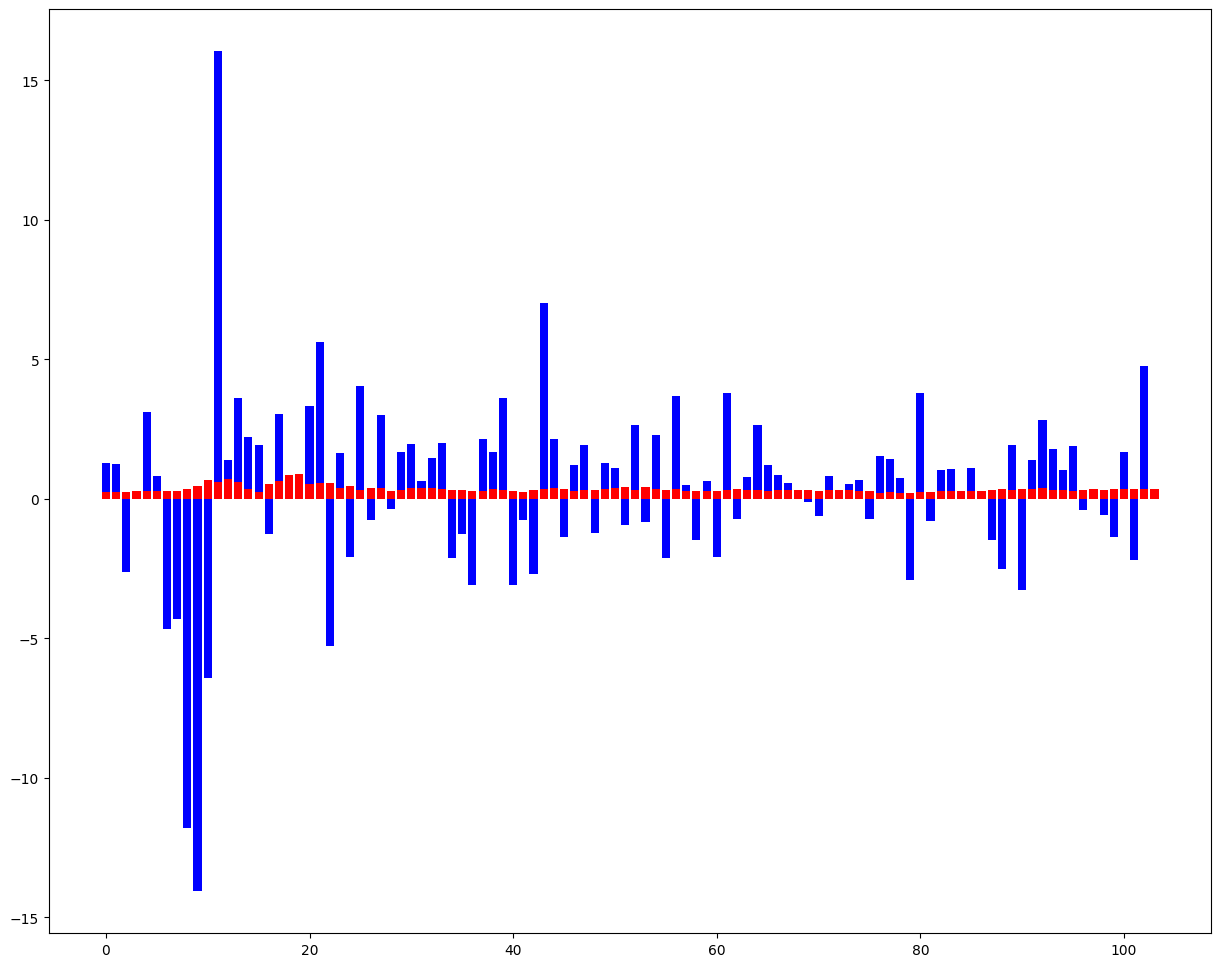

In [ ]:
cnn_mse = mean_squared_error(y_return_valid, y_return_pred)
cnn_rmse = np.sqrt(cnn_mse)
print(f"The baseline naive forecast to 'beat' is - MSE: {naive_mse:.2f}%, RMSE: {naive_rmse:.2f}%")
print(f"CNN's forecast - MSE: {cnn_mse:.2f}%, RMSE: {cnn_rmse:.2f}%")

fig, ax = plt.subplots(figsize = (15,12))

ax.bar(range(len(y_return_valid)),y_return_valid, color='blue', label= 'Actual')
ax.bar(range(len(y_return_pred)),y_return_pred, color='red', label='Prediction')

plt.show()
ax.set(title="CNN's Forecasts",
       xlabel='Time',
       ylabel='% Change')
ax.legend()

plt.show()

We beat the 'naive estimate' by a good measure, but these are not results we can rely on. Most predictions are above
zero, and are largely flat (not responding to peaks and troughs). Little was 'learned' from the weekly returns data,
resulting in a impractical model.

Finally, we will compare the index price predictions against the returns predictions
- *Note: we can add 'forecasted return' to the previously-observed price to form a 'forecast price'.*

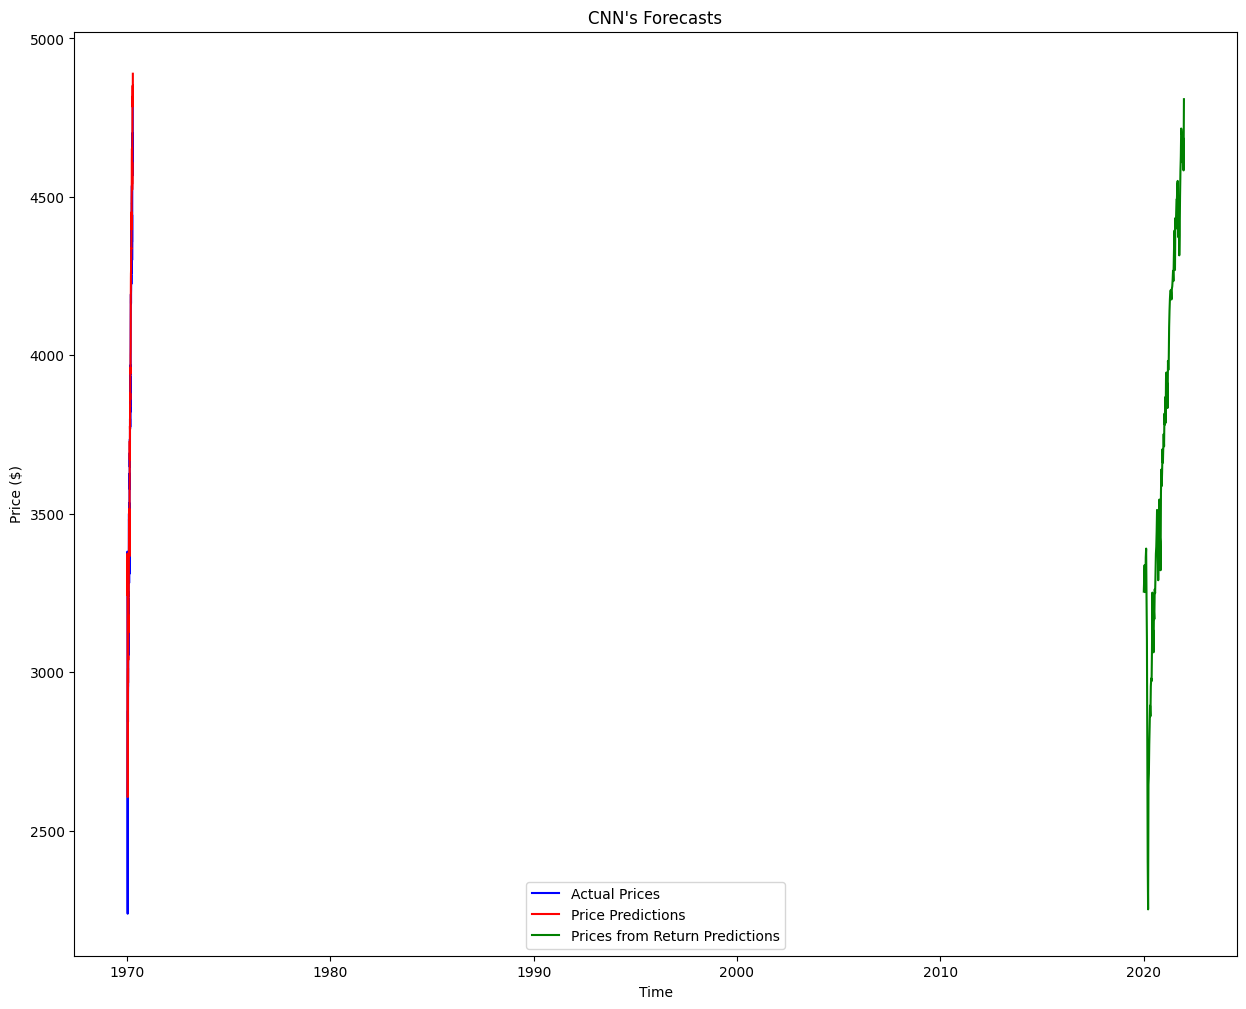

In [ ]:
fig, ax = plt.subplots(figsize = (15,12))

ax.plot(y_price_valid, color='blue', label='Actual Prices')
ax.plot(y_price_pred, color='red', label='Price Predictions')
ax.plot(naive_valid_price+ ((y_return_pred/100)*naive_valid_price), color='green', label='Prices from Return Predictions')

ax.set(title="CNN's Forecasts",
       xlabel='Time',
       ylabel='Price ($)')
ax.legend()

plt.show()

Again - rather poor forecasts that mostly resemble the previously-observed price.

## Final Thoughts

To sum up, it is inadvisable to attempt to predict stock / index prices or returns on the basis of their historical observations alone.
Historical price alone cannot be relied upon to generate an accurate vision of the future. We have demonstrated that while stock / index
price predictions may seem accurate, the best-fit networks generally fall back to momentum trading patterns, where the best guess
for tomorrow's price is today's price.

### Financial Theory Explanation

This is actually a long-held theory in Finance - the process underlying stock prices is believed to be a Martingale,
which is a statistical property that boils down to 'today's price is the discounted value of all possible future stock
prices, assuming risk neutral probability', or in other words, 'today's price is the best estimate of the market's
information about a stock'.

The algorithm has no agency - it is unaware that it is adopting a well-known 'naive' trading strategy.
What is actually happening is that no unique information is being extracted from the historical data, and so in lieu of any organic
predictive capability, it adopts the previously-observed price as today's since it has such a high correlation value.

### Statistical Explanation

Beyond that, though, some of the pre-processing steps, and even the data selection process, can be improved upon. First off, prior 'index
prices' cannot be used as a predictor variable in the first place because it is not scale invariant - dollar value changes in a high-value stock
are much greater than dollar value changes in a stock when the stock price is low.

As such, there is an inherent issue with predicting raw stock prices - the same network cannot generalise to make predictions when
the stock price is at different scale. Note that this is the expected outcome over time - stock prices are supposed to increase
over time, because otherwise, why would people invest?

Consider a stock price that shoots up from 3€ to 50€ over the course of 6 months. A 1€ change would have been massively influential
to this stock when it was at 3€ - a 33% daily change. A 1€ change would only have been a mild eye-catcher when it was at 50€, however - a 2% daily change.

On the other hand, by predicting returns, you can keep the scale invariance trait, because the 'value' to be predicted is relative to the current share price.

This means it can be compared against previous periods in the same stock, when it was at a much higher or lower price level, and it can
also be compared like-for-like with other stocks that may be at different price points.

From this, you may deduce that a preferred approach is to use stock returns - in our case, log-percentage changes in price.

Nevertheless, we found a similar lack of adaptability within our model to stock returns despite the high correlations in the data.

What we need to find is the **_drivers_** of the time series - what causes it to move up/down?

This is what we will search for in E-tivity 3.